# Final Project
## Estimation of a car position to solve a case of a bank robbery using GPS and radar data.
### Skoltech, 2023

In [55]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from datetime import datetime
from matplotlib.dates import date2num
import warnings
warnings.filterwarnings('ignore')

# Control variables
np.random.seed(42)  # Predefined random seed
labelsize = 15  # Label font size
titlesize = 20  # Title font size

## Formulation
A car left a site A at 00:00:00 and in around 16 minutes reached  some  point M. Suddenly a warning came that at 00:04:28 there was a bank robbery on 112 000 000 euros. The GPS coordinates of the bank are known (2.320446221708407e+03; 1.257888097981129e+03) in meters. Police knows that the car might have been taking the route close to the bank. In their availability there are space measurements from GPS and ground-bases measurements from a radar, but they are quite noisy to be 100% sure that this car was at around the bank at this specific time. Please answer did the car was at the location of the bank at 00:04:28?

### Step 0:
Define bank coordinates and time of the vehicle

In [56]:
# Determining position of the bank
bank = np.array((2.320446221708407e+03, 1.257888097981129e+03))

# Determing the time of vehicle
car_time = date2num(datetime(2021, 1, 1, hour=0, minute=4, second=28))

### Step 1:
Load the GPS data:
* Element in the first column - measurements of the coordinate x
* Element in the second column - measurements of the coordinate y

The measurements are available with gaps (at odd(нечетный) time moments).

In [57]:
# Loading GPS information
z_GPS = np.loadtxt('z_GPS.txt').T

### Step 2:
Load the RADAR data:
* First row –measurements of the coordinate x
* Second row –measurements of the coordinate y

The measurements are available with gaps (at even(четный) time moments).

In [58]:
# Loading RADAR information
z_RADAR = np.loadtxt('z_RADAR.txt').T

# Swapping two columns between (Range <-> Azimuth)
# (Так проще не запутаться дальше в расчетах, теперь первый столбец - Азимут, а второй - Дистанция до объекта)
z_RADAR[[0, 1], :] = z_RADAR[[1, 0], :]

### Step 3:
Load time information of measurements, columns: year, month, day, hour, minute, second

In [59]:
# Read the data from TXT file using Pandas.
# The data does not have headers, so we will assign them manually.
column_names = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']
data_time = pd.read_csv('time.txt', delim_whitespace=True, header=None, names=column_names)

# Converting raw data into datetime python format
time = list()
for _, row in data_time.iterrows():
    time.append(datetime(int(row['Year']), int(row['Month']), int(row['Day']), hour=int(row['Hour']), minute=int(row['Minute']), second=int(row['Second'])))
    # This function makes the dates compatible with Matplotlib functions.
time = date2num(time)

### Step 4:
Plot the loaded data:
* GPS raw measurements
* RADAR raw measurements

Determine position of the bank (2.320446221708407e+03; 1.257888097981129e+03) in the plots.

In [60]:
# Define necessary functions

# Convert polar coordinates to Cartesian coordinates
def p2c(azimuth, range_):
    """Polar to Cartesian (p2c) conversion

    Args:
        azimuth - Azimuth angle of an object
        range_ - Distance to an object

    Returns:
        x - Coordinate X in Cartseian coordinate system
        y - Coordinate Y in Cartesian coordinate system
    """
    x = range_ * np.sin(azimuth)
    y = range_ * np.cos(azimuth)
    return x, y

# Convert Cartesian coordinates to polar coordinates
def c2p(x, y):
    """Cartesian to Polar (c2p) conversion

    Args:
        x - Coordinate X in Cartseian coordinate system
        y - Coordinate Y in Cartesian coordinate system
    Returns:
        azimuth - Azimuth angle of an object
        range_ - Distance to an object
    """
    range_ = np.sqrt(x**2 + y**2)
    azimuth = np.arctan2(x, y)
    return azimuth, range_

# Get position of the vehicle
def get_pos(cord_1_arr, cord_2_arr, time_arr=time, car_time=car_time):
    """Get position of the vehicle at specific time

    Args:
        time_arr - Time array
        cord_1_arr - Coordinate 1 (X or Azimuth) array
        cord_2_arr - Coordinate 2 (Y or Range) array

    Returns:
        cord_1 - Coordinate 1 at specific time
        cord_2 - Coordinate 2 at specific time
    """
    for i in range(len(time_arr)):
        if time[i] == car_time:
            if np.isnan(cord_1_arr[i]): # if x = nan
                cord_1 = (cord_1_arr[i + 1] + cord_1_arr[i - 1]) / 2
                cord_2 = (cord_2_arr[i + 1] + cord_2_arr[i - 1]) / 2
                return cord_1, cord_2
            else:
                return cord_1_arr[i], cord_2_arr[i]

# Get range from car to bank
def get_car_bank_dist(car_pos, bank_pos=bank):
    """Get distance from car to bank
    
    Args:
        car_pos - Car position (x, y)
        bank_pos - Bank position (x, y)
    
    Returns:
        dist - Distance from car to bank
    """
    dist = np.sqrt((car_pos[0] - bank_pos[0])**2 + (car_pos[1] - bank_pos[1])**2 )
    return print(f'Car is {dist:0.2f} meters far from the bank!')

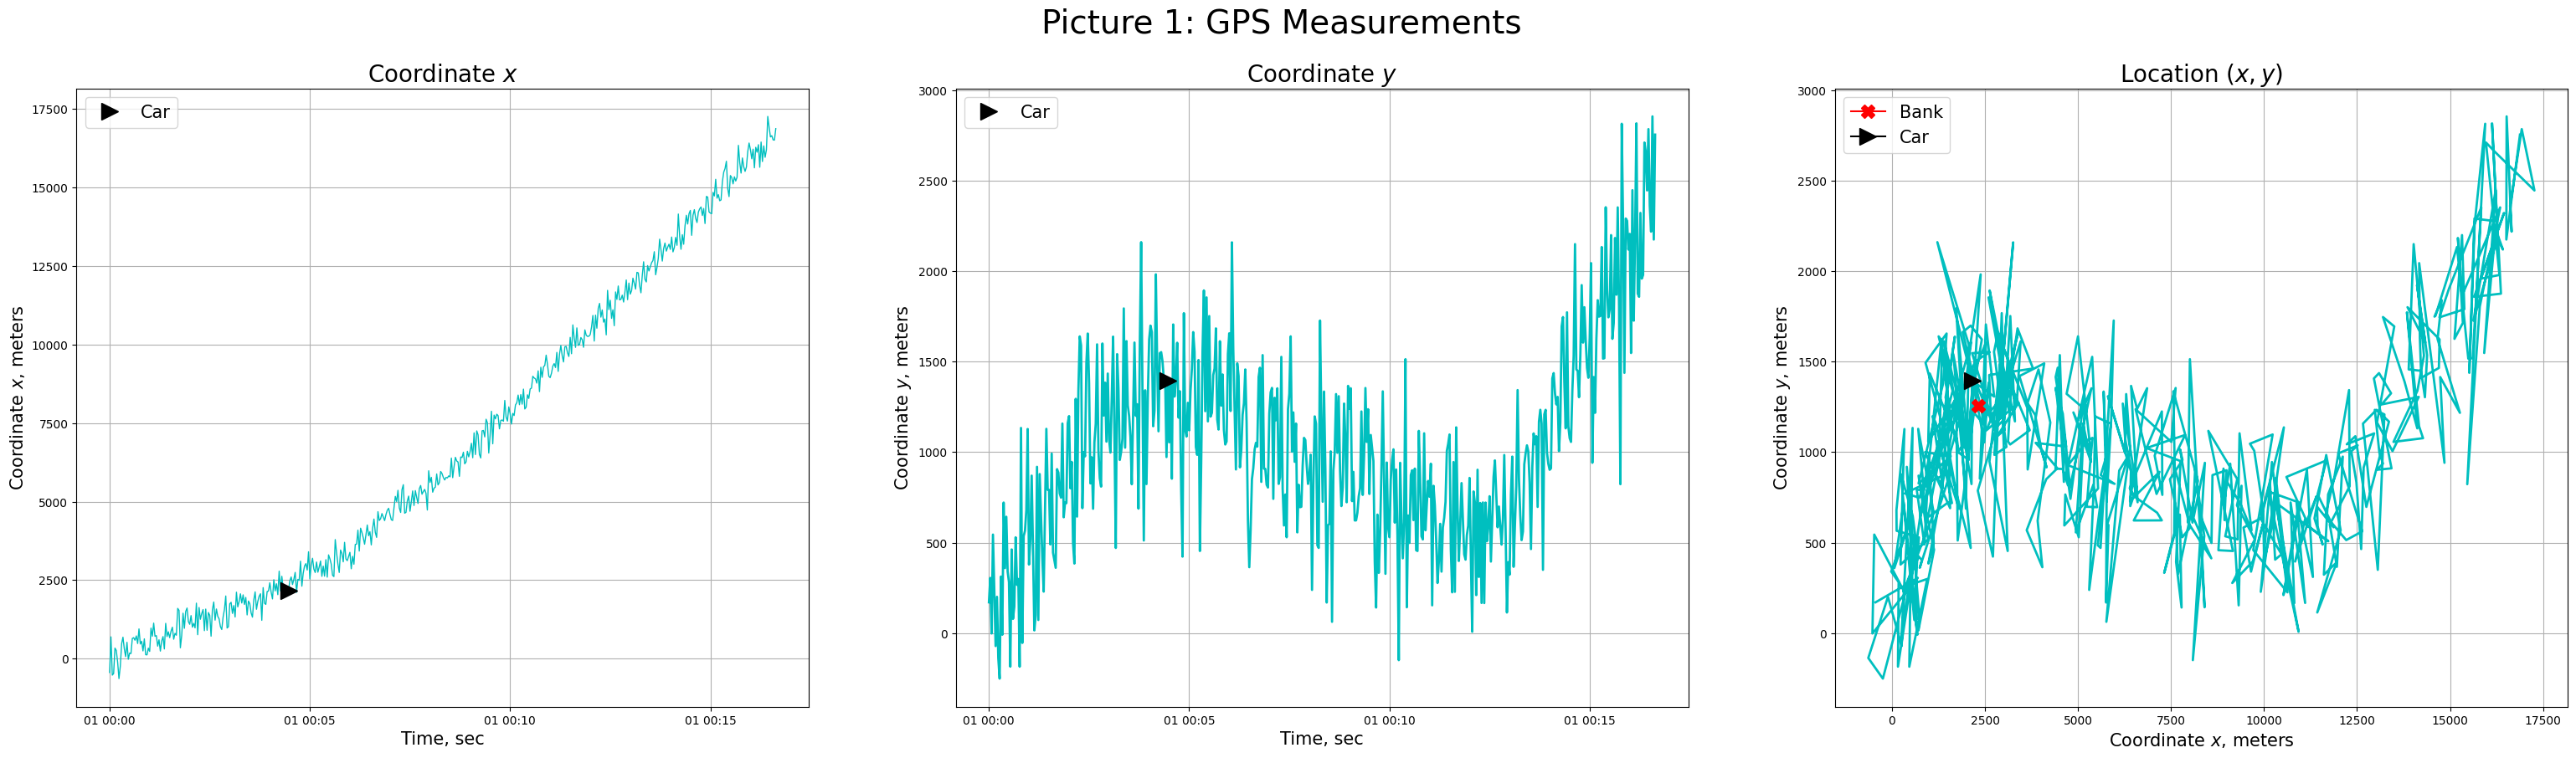

In [61]:
# GPS data plot
# Get the position of the vehicle based only on GPS data
gps_car_pos = get_pos(*z_GPS)

# Set up a figure
fig = plt.figure(figsize=[6.4*6, 4.8*2])
fig.suptitle('Picture 1: GPS Measurements', fontsize=28)

# Coordinate X plot
ax = fig.add_subplot(1, 3, 1)
ax.plot_date(time[::2], z_GPS[0, ::2], lw=1, color='c', ls='-', marker=None)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_title('Coordinate $x$', fontsize=titlesize)
# Determining vehicle position
ax.plot_date(car_time, gps_car_pos[0], label='Car', marker='>', color='k', markersize=15)
ax.legend(loc='best', fontsize=labelsize)

# Coordinate Y
ax = fig.add_subplot(1, 3, 2)
ax.plot_date(time[::2], z_GPS[1, ::2], lw=2, ls='-', c ='c', marker=None)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Coordinate $y$', fontsize=titlesize)
# Determining vehicle position
ax.plot_date(car_time, gps_car_pos[1], label='Car', marker='>', color='k', markersize=15)
ax.legend(loc='best', fontsize=labelsize)

# Location (X, Y)
ax = fig.add_subplot(1, 3, 3)
ax.plot(z_GPS[0, ::2], z_GPS[1, ::2], lw=2, color='c', ls='-', marker=None)
# Determining position of the bank
ax.plot(*bank, label='Bank', marker='X', color='red', markersize=12)
# Determining vehicle position
ax.plot(*gps_car_pos, label='Car', marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Location ($x, y$)', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

plt.show()

In [62]:
# Let's understand how far the car from bank if we assume only GPS data
get_car_bank_dist(gps_car_pos)

Car is 201.02 meters far from the bank!


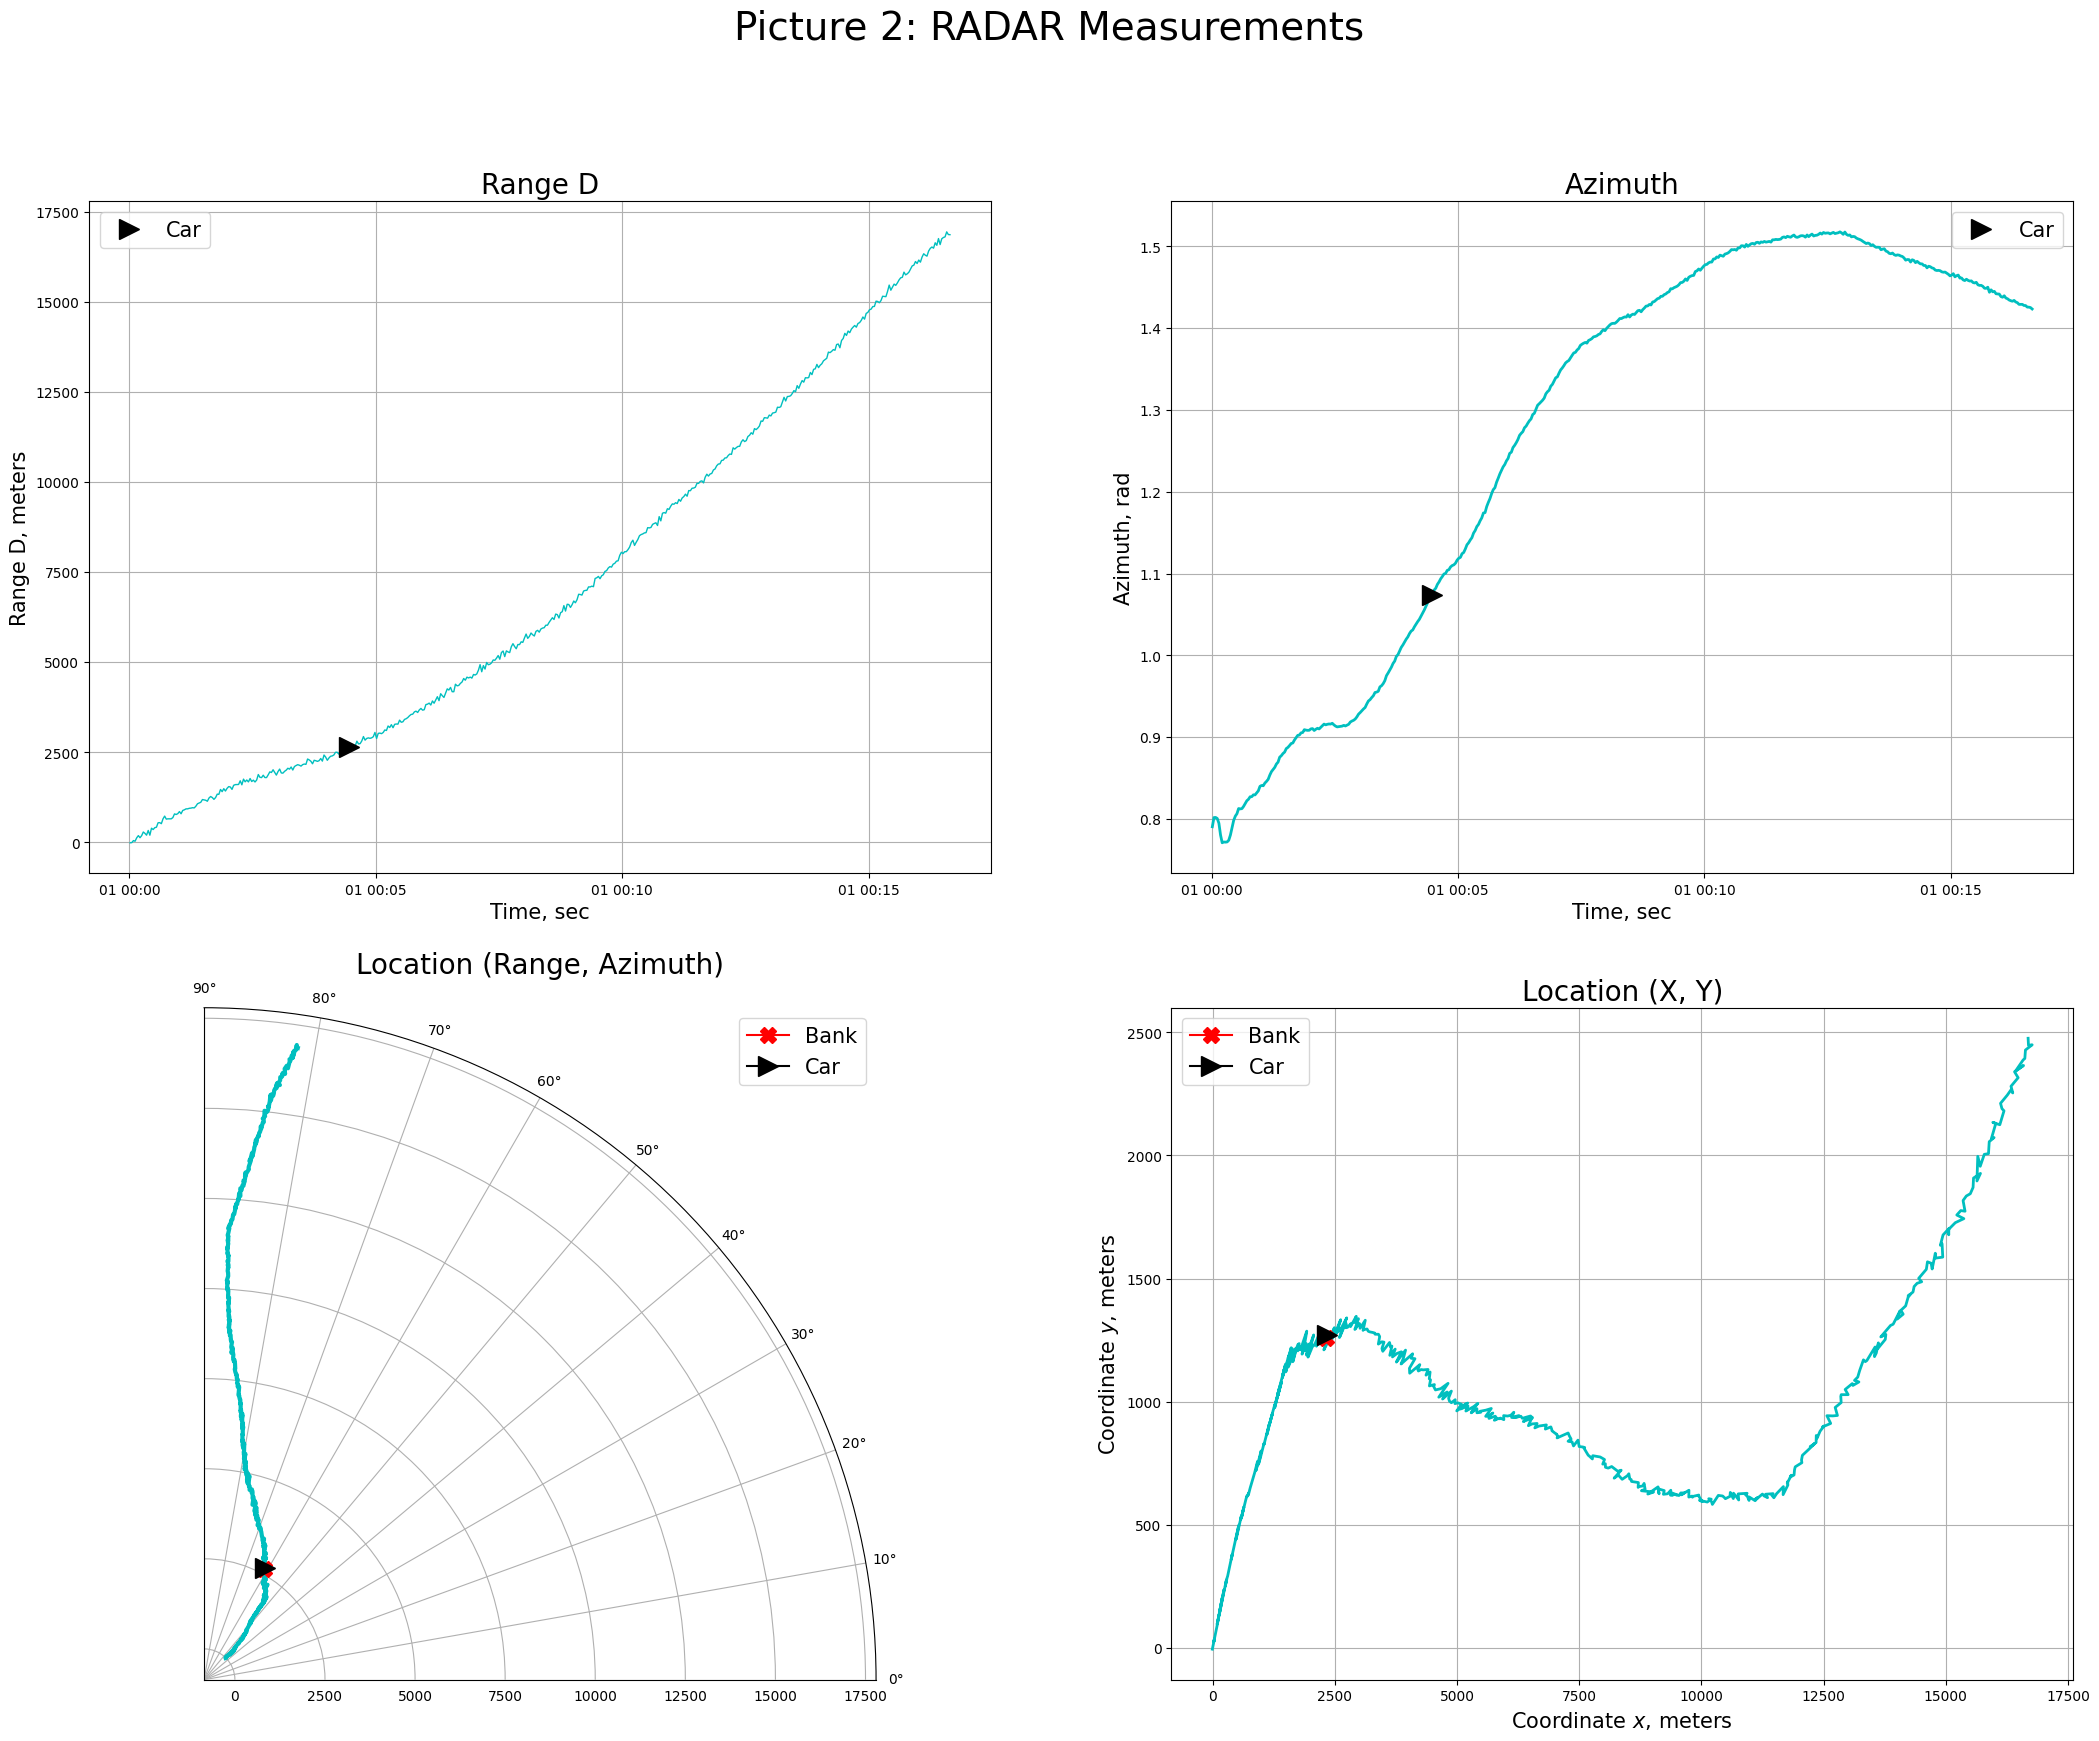

In [78]:
# RADAR data plot
# Get the position of the vehicle based only on RADAR data
radar_car_pos = get_pos(*z_RADAR)

# Set up a figure
fig = plt.figure(figsize=[6.4*4, 4.8*4])
fig.suptitle('Picture 2: RADAR Measurements', fontsize=28)

# Range D
ax = fig.add_subplot(2, 2, 1)
ax.plot_date(time[1::2], z_RADAR[1, 1::2], lw=1, color='c', ls='-', marker=None)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Range D, meters', fontsize=labelsize)
ax.set_title('Range D', fontsize=titlesize)
# Determining vehicle position
ax.plot_date(car_time, radar_car_pos[1], label='Car', marker='>', color='k', markersize=15)
ax.legend(loc='best', fontsize=labelsize)

# Azimuth
ax = fig.add_subplot(2, 2, 2)
ax.plot_date(time[1::2], z_RADAR[0, 1::2], lw=2, color='c', ls='-', marker=None)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Azimuth, rad', fontsize=labelsize)
ax.set_title('Azimuth', fontsize=titlesize)
# Determining vehicle position
ax.plot_date(car_time, radar_car_pos[0], label='Car', marker='>', color='k', markersize=15)
ax.legend(loc='best', fontsize=labelsize)

# Location (Range, Azimuth)
ax = fig.add_subplot(2, 2, 3, projection='polar')
ax.plot(*z_RADAR[:, 1::2], lw=3, color='c', ls='-', marker=None)
# Plot decoration
ax.grid(True)
ax.set_title('Location (Range, Azimuth)', fontsize=titlesize)
ax.set_xlim([0, np.pi / 2])
# Determining position of the bank
ax.plot(*c2p(*bank), label='Bank', marker='X', color='red', markersize=12)
# Determining vehicle position
ax.plot(*radar_car_pos, label='Car', marker='>', color='k', markersize=15)
ax.legend(loc='best', fontsize=labelsize)

# Location (X, Y)
ax = fig.add_subplot(2, 2, 4)
ax.plot(*np.asarray(p2c(*z_RADAR))[:, 1::2], lw=2, color='c', ls='-')
# Plot decoration
ax.grid(True)
ax.set_xlabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Location (X, Y)', fontsize=titlesize)
# Determining position of the bank
ax.plot(*bank, label='Bank', marker='X', color='red', markersize=12)
# Determining vehicle position
ax.plot(*p2c(*radar_car_pos), label='Car',  marker='>', color='k', markersize=15)
ax.legend(loc='best', fontsize=labelsize)

plt.show()

In [64]:
# Let's understand how far the car from bank if we assume only RADAR data
get_car_bank_dist(p2c(*radar_car_pos))

Car is 21.66 meters far from the bank!


### Step 5:
Construct the Linear Kalman filter using only GPS data sets.

In [65]:
# Initial Conditions
T = 1        # Time step, s
std_x = 300  # Standart deviation of GPS coordinate X measurement noise
std_y = 300  # Standart deviation of GPS coordinate Y measurement noise
std_a = 0.3  # Standart deviation of process noise

# Transition matrix Phi
Phi = np.matrix([[1, T, 0, 0],  # x = x_i-1 + V_x*T - тут не учитывается угол
                 [0, 1, 0, 0],  
                 [0, 0, 1, T],  # y = y_i-1 + V_y*T
                 [0, 0, 0, 1]])

# Input gain matrix G
G = np.matrix([[T**2 / 2, 0],   # x = .... + A_x * T^2 / 2
               [T, 0],          # v_x = .... + A_x - почему тут учитывается ускорение
               [0, T**2 / 2],
               [0, T]])

# Observation matrix H
H = np.matrix([[1, 0, 0, 0],  # x - output
               [0, 0, 1, 0]]) # y - output

# State noise coavariance matrix Q
Q = G @ G.T * std_a**2  # Мы заменяем здесь std_a на 5 для того чтобы повысить дисперсии шумов процесса для того чтобы K был более агрессивным и мы могли сгладить несовершенства динамической модели, 
                    # потому что динамическая модель в калман фильтре будет отличаться от динамической модели реальной траектории где учитывалась нелинейность в виде угла тетта.

# Measurement noise covariance matrix R
R = np.matrix([[std_x**2, 0],
               [0, std_y**2]])

# Initial filtered state vector X_0
X_0 = np.matrix([         z_GPS[0, 0],                  # x_0
                 (z_GPS[0, 2] - z_GPS[0, 0]) / 2*T,     # vx_0
                          z_GPS[1, 0],                  # y_0
                 (z_GPS[1, 2] - z_GPS[1, 0]) / 2*T]     # vy_0
                ).T      

# Initial filtration covariance matrix P_0
P_0 = np.matrix([[10**4, 0, 0, 0],
                 [0, 10**4, 0, 0],
                 [0, 0, 10**4, 0],
                 [0, 0, 0, 10**4]])

# Define return function object
KalmanResult = namedtuple('KalmanResult', ('x_adj', 'y_adj', 'x_pred', 'y_pred', 'X_adjust', 'X_predict', 'K',  'P_adjust', 'P_predict', 'P'))

def kalman_filter(Z, Phi=Phi, H=H, Q=Q, R=R, X_0=X_0, P_0=P_0) -> KalmanResult:
    """
    Внимание, в данной функции используется шаг 2, а не один, так как в текущих данных есть пропуски.
    А сами значения заполнены на нечетных индексах.
    """
    # Define the sizes of predicted and adjusted arrays
    X_predict = np.matrix(np.zeros((len(Phi), Z.shape[1])))
    X_adjust = np.matrix(np.zeros((len(Phi), Z.shape[1])))
    # Define initial value of X
    X_adjust[:, 2] = X_0
    # Define the size of covariance matrix P
    P_predict = np.zeros((Z.shape[1], len(P_0), len(P_0)))
    P_adjust = np.zeros((Z.shape[1], len(P_0), len(P_0)))
    # Define initial value of P
    P_adjust[2, :, :] = P_0
    # Cycle algorithm
    for i in range(4, Z.shape[1], 2):
        # Step 1. Prediction of a state vector at time i using i-1 measurements
        # I. Calculate prediction
        X_predict[:, i] = np.dot(Phi, X_adjust[:, i - 2])
        # II. Calculate prediction of covariance matrix
        P_predict[i, :, :] = np.dot(np.dot(Phi, P_adjust[i - 2, :, :]), Phi.T) + Q
        # Step 2. Adjustment of predicted estimate
        # I. Calculate filter gain, weight of residual
        lp = np.dot(P_predict[i, :, :], H.T) # Left part of K
        rp = np.linalg.inv(np.dot(np.dot(H, P_predict[i, :, :]), H.T) + R)  # Right part of K
        K = np.dot(lp, rp)
        # II. Calculate improved estimate by incorporating a new measurement
        X_adjust[:, i] = X_predict[:, i] + K * (np.asmatrix(Z[:, i]).T - np.dot(H, X_predict[:, i]))
        # III. Calculate filtration error covariance matrix
        I = np.eye(len(np.dot(K, H)))
        P_adjust[i, :, :] = np.dot((I - np.dot(K, H)), P_predict[i, :, :])
    # Return neccesary values
    P = P_adjust[-1, :, :]  # Resulted covariance matrix
    # Return x and y adjusted
    x_adj = np.asarray(X_adjust[0])[0]
    y_adj = np.asarray(X_adjust[2])[0]
    # Return x and y predicted
    x_pred = np.asarray(X_predict[0])[0]
    y_pred = np.asarray(X_predict[2])[0]

    return KalmanResult(x_adj, y_adj, x_pred, y_pred, X_adjust, X_predict, K,  P_adjust, P_predict, P)

est_1 = kalman_filter(z_GPS)


### Step 6:
Plot the results of Linear Kalman filter using only GPS data sets.

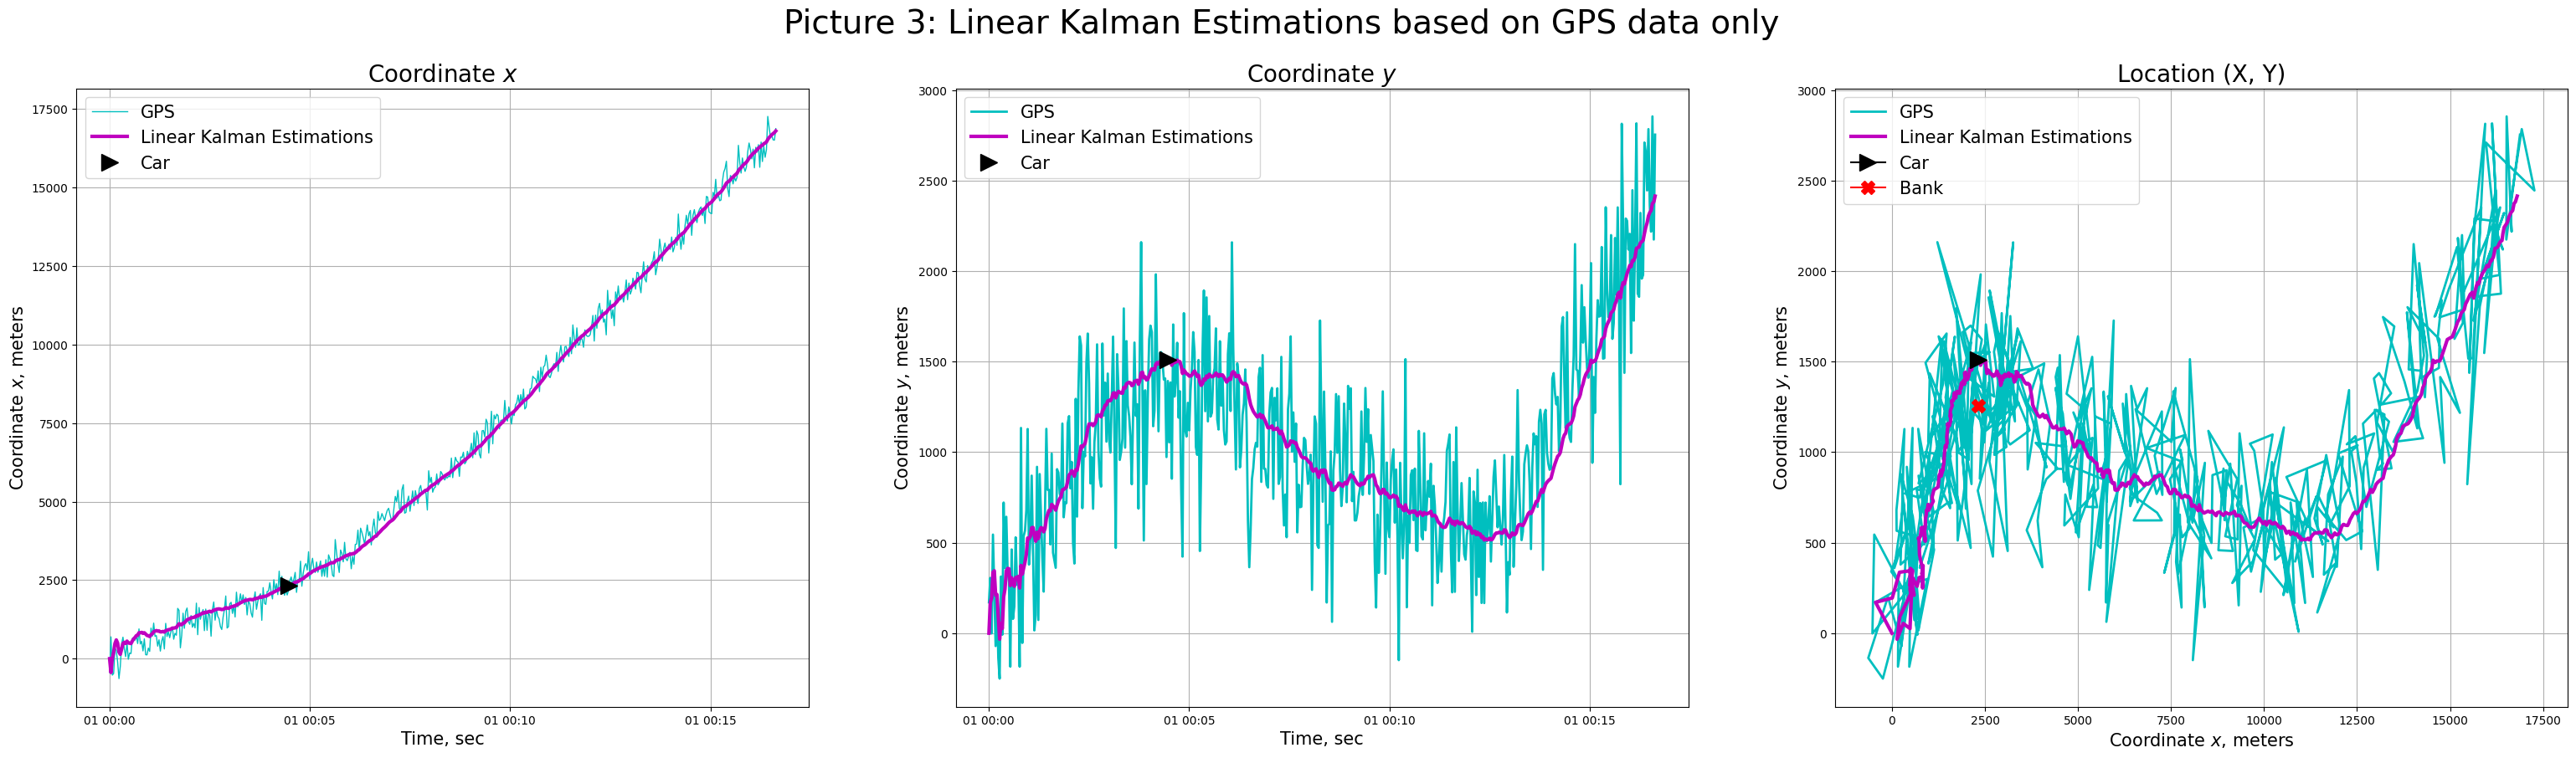

In [82]:
# GPS data plot
# Get the estimated car position
est_1_car_pos = get_pos(est_1.x_adj, est_1.y_adj)

# Set up a figure
fig = plt.figure(figsize=[6.4*6, 4.8*2])
fig.suptitle('Picture 3: Linear Kalman Estimations based on GPS data only', fontsize=28)

# Coordinate X plot
ax = fig.add_subplot(1, 3, 1)
ax.plot_date(time[::2], z_GPS[0, ::2], lw=1, color='c', ls='-',  label='GPS',  marker=None)
ax.plot_date(time[::2], est_1.x_adj[::2], lw=3, color='m', ls='-', label='Linear Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_1_car_pos[0], label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_title('Coordinate $x$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Coordinate Y
ax = fig.add_subplot(1, 3, 2)
ax.plot_date(time[::2], z_GPS[1, ::2], lw=2, ls='-', color ='c',  label='GPS' , marker=None)
ax.plot_date(time[::2], est_1.y_adj[::2], lw=3, color='m', ls='-', label='Linear Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_1_car_pos[1], label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Coordinate $y$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Location (X, Y)
ax = fig.add_subplot(1, 3, 3)
ax.plot(z_GPS[0, ::2], z_GPS[1, ::2], lw=2, color='c', ls='-', marker=None, label='GPS')
ax.plot(est_1.x_adj[::2], est_1.y_adj[::2], lw=3, color='m', ls='-', label='Linear Kalman Estimations')
# Determining vehicle position
ax.plot(*est_1_car_pos, label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Location (X, Y)', fontsize=titlesize)

# Determining position of the bank
ax.plot(*bank, label='Bank', marker='X', color='red', markersize=12)
ax.legend(loc='best', fontsize=labelsize)

plt.show()

In [67]:
# Let's understand how far the car from bank if we assume only RADAR data
get_car_bank_dist(est_1_car_pos)

Car is 253.52 meters far from the bank!


**Conclusion 1:**

According to the estimated data on GPS, it cannot be said that the car was at the bank at the specified time.

### Step 7:
Develop optimal smoothing to Kalman filter estimates and improve estimation results.

In [68]:
# Define return function object
SmoothedResult = namedtuple('SmoothedResult', ('X_smooth', 'x_sm', 'y_sm', 'P_smooth', 'A_hist', 'A'))

def optimal_smoothing(Phi, P_adjust, P_predict, X_adjust) -> SmoothedResult: 
    """ Backward Kalman Filter Smoothing

    Function performs optimal backward Kalman smoothing algorithm.
        I.  Calculate smoothing coefficient A
        II. Calculate smoothing state vector trajectory
        III.Calculate smoothing error covariance matrix
             
    For more info please refer https://skoltech.instructure.com/courses/3429/assignments/18591. 

    Note:
        Внимание, в этой функции изменены индексы, так как она принимает на вход данные с пропусками притом только на четных позициях.
        Если данные без пропусков, то воспользуйся функцией из библиотеки edplib.py
        
    Args:
        Phi - Transition matrix of a system
        P_adjust - Adjusted error evaluation matrix
        P_predict - Predicted error evaluation matrix
        X_adjust- Filtered state vector trajectory

    Returns:
        SmoothedResult - namedtuple object
        X_smoothed - State vector trajectory
        x_sm - Coordinate vector trajectory
        v_sm - Velocity vector trajectory
        P_smooth - Smoothing error covariance matrix

    """
    # Define X_smooth array shape
    X_smooth = np.matrix(np.zeros(np.shape(X_adjust)))
    # Define initial smoothing vector value 
    X_smooth[:, -2] = X_adjust[:, -2]
    # Define P_smooth array shape
    P_smooth = np.zeros(np.shape(P_adjust))
    # Define initial value of Smoothing error covariance matrix
    P_smooth[-2, :, :] = P_adjust[-2, :, :]
    # Define the amount of the iterations    
    size = np.shape(X_adjust)[1]
    # Define the size of Smoothing coefficient
    A_shape = np.matrix(P_adjust[-2, :, :] @ Phi.T @ np.linalg.inv(P_predict[-2, :, :]))
    A_hist = np.zeros((size, np.shape(A_shape)[0], np.shape(A_shape)[1]))
    # Algorithm
    for i in range(size - 4, 0, -2):  # Start smoothing from penultimate (предпоследний) element
        # Calculate Smoothing Coefficient
        A = P_adjust[i, :, :] @ Phi.T @ np.linalg.inv(P_predict[i + 2, :, :])
        A_hist[i, :, :] = A
        # Calculate Smoothed Value
        X_smooth[:, i] = X_adjust[:, i] + A @ (X_smooth[:, i + 2] - Phi @ X_adjust[:, i])
        # Calculate Smoothing error covariance matrix
        P_smooth[i, :, :] = P_adjust[i, :, :] + A @ (P_smooth[i + 2, :, :] - P_predict[i + 2, :, :]) @ A.T
    # Return
    x_sm = np.reshape(np.array(X_smooth[0, :]), -1)  # Return smoothed coordinate trajectory
    y_sm = np.reshape(np.array(X_smooth[2, :]), -1)  # Return smoothed velocity trajectory

    return SmoothedResult(X_smooth, x_sm, y_sm, P_smooth, A_hist, A)

est_2 = optimal_smoothing(Phi, est_1.P_adjust, est_1.P_predict, est_1.X_adjust)

### Step 8:
Plot the results of Smoothed Linear Kalman filter using only GPS data sets.

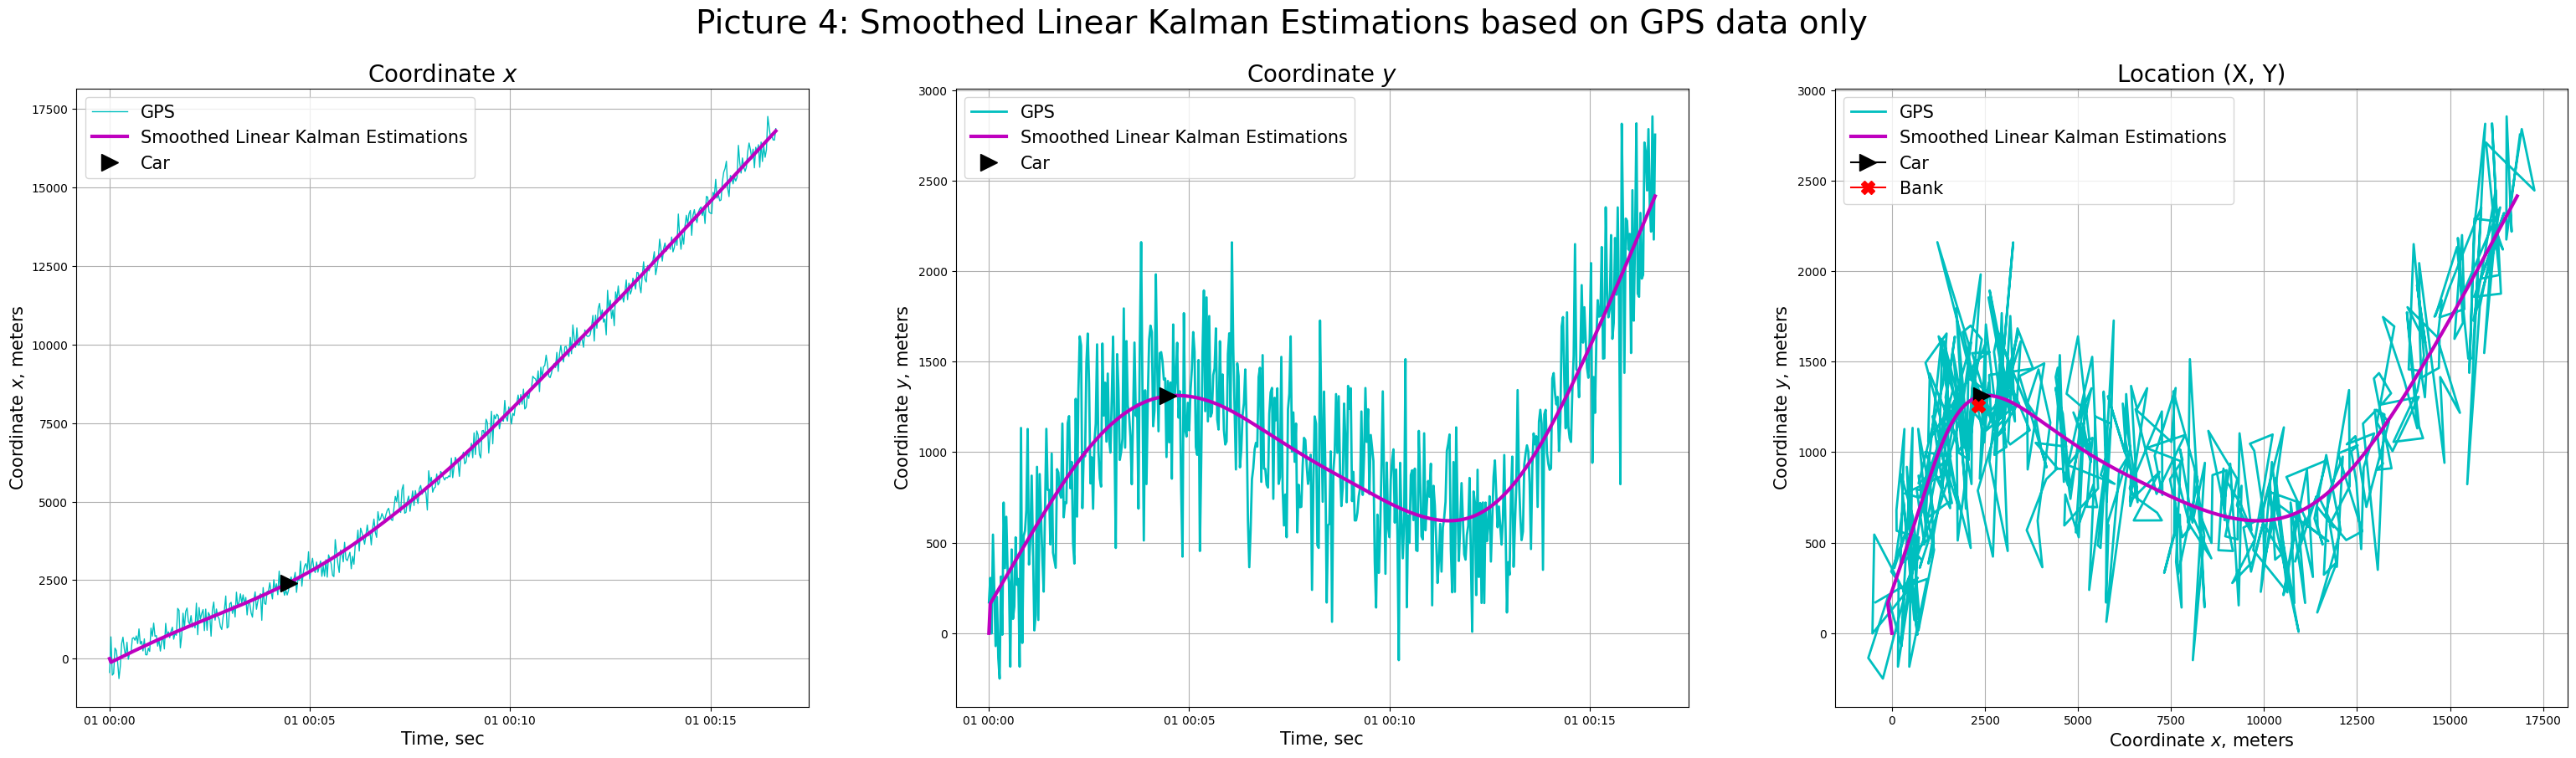

In [85]:
# GPS data plot
# Get the estimated car position
est_2_car_pos = get_pos(est_2.x_sm, est_2.y_sm)

# Set up a figure
fig = plt.figure(figsize=[6.4*6, 4.8*2])
fig.suptitle('Picture 4: Smoothed Linear Kalman Estimations based on GPS data only', fontsize=28)

# Coordinate X plot
ax = fig.add_subplot(1, 3, 1)
ax.plot_date(time[::2], z_GPS[0, ::2], lw=1, color='c', ls='-',  label='GPS', marker=None)
ax.plot_date(time[::2], est_2.x_sm[::2], lw=3, color='m', ls='-', label='Smoothed Linear Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_2_car_pos[0], label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_title('Coordinate $x$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Coordinate Y
ax = fig.add_subplot(1, 3, 2)
ax.plot_date(time[::2], z_GPS[1, ::2], lw=2, ls='-',  label='GPS', color = 'c',  marker=None)
ax.plot_date(time[::2], est_2.y_sm[::2], lw=3, color='m', ls='-', label='Smoothed Linear Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_2_car_pos[1], label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Coordinate $y$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Location (X, Y)
ax = fig.add_subplot(1, 3, 3)
ax.plot(z_GPS[0, ::2], z_GPS[1, ::2], lw=2, color='c', ls='-', marker=None, label='GPS')
ax.plot(est_2.x_sm[::2], est_2.y_sm[::2], lw=3, color='m', ls='-', label='Smoothed Linear Kalman Estimations')
# Determining vehicle position
ax.plot(*est_2_car_pos, label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Location (X, Y)', fontsize=titlesize)

# Determining position of the bank
ax.plot(*bank, label='Bank', marker='X', color='red', markersize=12)
ax.legend(loc='best', fontsize=labelsize)

plt.show()

In [70]:
# Let's understand how far the car from bank if we assume only RADAR data
get_car_bank_dist(est_2_car_pos)

Car is 104.11 meters far from the bank!


**Conclusion 2:**

According to the smoothed estimated data based on GPS, it cannot be said that the car was at the bank at the specified time.

### Step 9:
Develop the filter, which account for both GPS (at odd time steps) and more accurate RADAR data (at even time steps) using the idea of joint assimilation of measurements.

In [71]:
# Initial Conditions
std_range = 50      # Standart deviation of RADAR range D measurement noise
std_azimuth = 0.01  # Standart deviation of RADAR Azimuth measurement noise

# Define functions for Extended Kalman filter for RADAR measurements
def nonlinear_H(x, y):
    H = np.array([np.sqrt(x**2 + y**2), np.arctan2(x, y)])
    return H

def linearize_dh_dx(x, y):
    # Define matrix size
    dh_dx = np.zeros((2,4))
    dh_dx[0, 0] = x / np.sqrt(x**2 + y**2)
    dh_dx[0, 2] = y/ np.sqrt(x**2 + y**2)
    dh_dx[1, 0] = y / (x**2 + y**2)
    dh_dx[1, 2] = - x / (x**2 + y**2)
    return dh_dx

# Measurement noise covariance matrix for RADAR
R_radar = np.matrix([[std_range**2, 0],
                     [0, std_azimuth**2]])     

# Initial filtration covariance matrix P_0
P_0 = np.matrix([[10**4, 0, 0, 0],
                 [0, 10**4, 0, 0],
                 [0, 0, 10**4, 0],
                 [0, 0, 0, 10**4]])

X_0 = np.matrix([1, 1, 1, 1]).T

# Swapping two columns between (Range <-> Azimuth)
# (Так проще не запутаться дальше в расчетах, теперь первый столбец - Азимут, а второй - Дистанция до объекта)
z_RADAR[[0, 1], :] = z_RADAR[[1, 0], :]

# Compose measurements into one vector
Z = np.zeros((2, z_GPS[1].size))
for i in range(z_GPS[1].size):
    if (i % 2) == 0:
    # even (четное, тут GPS)
        Z[:, i] = z_GPS[:, i]
    else:
        Z[:, i] = z_RADAR[:, i]
    # odd (нечетное, тут есть дистанция и азимут)

# Define return function object
KalmanResult = namedtuple('KalmanResult', ('x_adj', 'y_adj', 'x_pred', 'y_pred', 'X_adjust', 'X_predict', 'K', 'P_adjust', 'P_predict', 'P'))

def extended_kalman_filter(Z, Phi=Phi, X_0=X_0, P_0=P_0, Q=Q, R_GPS=R, R_radar=R_radar, H=H) -> KalmanResult:
    # Define the sizes of predicted and adjusted arrays
    X_predict = np.matrix(np.zeros((len(Phi), Z.shape[1])))
    X_adjust = np.matrix(np.zeros((len(Phi), Z.shape[1])))
    # Define initial value of X
    X_adjust[:, 0] = X_0
    # Define the size of covariance matrix P
    P_predict = np.zeros((Z.shape[1], len(P_0), len(P_0)))
    P_adjust = np.zeros((Z.shape[1], len(P_0), len(P_0)))
    # Define initial value of P
    P_adjust[0, :, :] = P_0
    # Define time variant array for Filter Gain
    # Cycle algorithm
    for i in range(1, Z.shape[1]):
        # Step 1. Prediction of a state vector at time i using i-1 measurements
        # I. Calculate prediction
        X_predict[:, i] = np.dot(Phi, X_adjust[:, i - 1])
        # II. Calculate prediction of covariance matrix
        P_predict[i, :, :] = np.dot(np.dot(Phi, P_adjust[i - 1, :, :]), Phi.T) + Q
        
        # Step 2. Adjustment of predicted estimate
        if (i % 2) != 0:
            # odd (нечетное, тут есть дистанция и азимут)
            # I. Calculate filter gain, weight of residual
            dh = linearize_dh_dx(X_predict[0, i], X_predict[2, i])
            lp = np.dot(P_predict[i, :, :], dh.T) # Left part of K
            rp = np.linalg.inv(np.dot(np.dot(dh, P_predict[i, :, :]), dh.T) + R_radar)  # Right part of K
            K = np.dot(lp, rp)
            # II. Calculate improved estimate by incorporating a new measurement
            H_X = np.matrix(nonlinear_H(X_predict[0, i], X_predict[2, i]))
            X_adjust[:, i] = X_predict[:, i] + np.dot(K,(Z[:, i] - H_X).T)
            # III. Calculate filtration error covariance matrix
            I = np.eye(len(np.dot(K, dh)))
            P_adjust[i, :, :] = np.dot((I - np.dot(K, dh)), P_predict[i, :, :])
        else:
            # even (четное, тут GPS и линеаризовывать не нужно)
            # I. Calculate filter gain, weight of residual
            lp = np.dot(P_predict[i, :, :], H.T) # Left part of K
            rp = np.linalg.inv(np.dot(np.dot(H, P_predict[i, :, :]), H.T) + R_GPS)  # Right part of K
            K = np.dot(lp, rp)
            # II. Calculate improved estimate by incorporating a new measurement
            X_adjust[:, i] = X_predict[:, i] + K * (np.asmatrix(Z[:, i]).T - np.dot(H, X_predict[:, i]))
            # III. Calculate filtration error covariance matrix
            I = np.eye(len(np.dot(K, H)))
            P_adjust[i, :, :] = np.dot((I - np.dot(K, H)), P_predict[i, :, :])
        
    # Return neccesary values
    P = P_adjust[-1, :, :]  # Resulted covariance matrix
    # Return x and y adjusted
    x_adj = np.asarray(X_adjust[0])[0]
    y_adj = np.asarray(X_adjust[2])[0]
    # Return x and y predicted
    x_pred = np.asarray(X_predict[0])[0]
    y_pred = np.asarray(X_predict[2])[0]
    return KalmanResult(x_adj, y_adj, x_pred, y_pred, X_adjust, X_predict, K, P_adjust, P_predict, P)

est_3 = extended_kalman_filter(Z)


### Step 10:
Plot the results of Extended Kalman filter using GPS and Radar data sets.

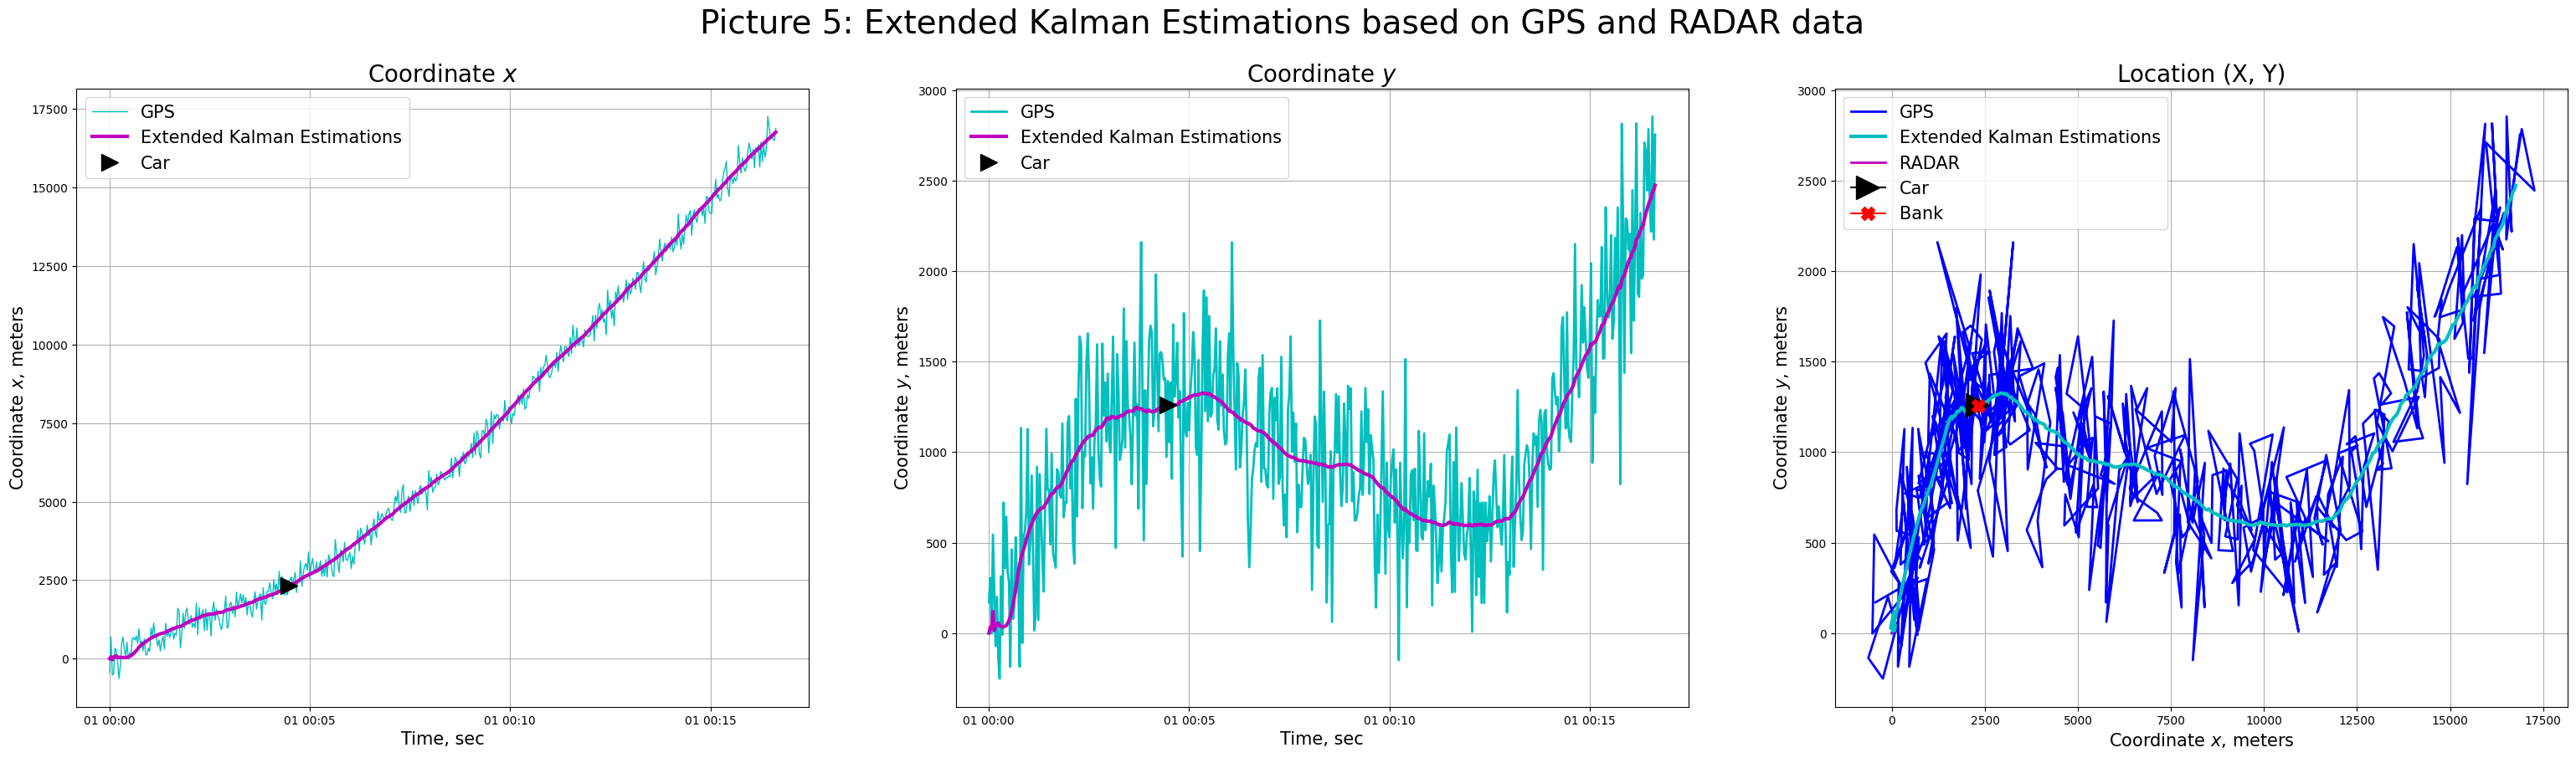

In [87]:
# GPS data plot
# Get the estimated car position
est_3_car_pos = get_pos(est_3.x_adj, est_3.y_adj)

# Set up a figure
fig = plt.figure(figsize=[6.4*6, 4.8*2])
fig.suptitle('Picture 5: Extended Kalman Estimations based on GPS and RADAR data', fontsize=28)

# Coordinate X plot
ax = fig.add_subplot(1, 3, 1)
ax.plot_date(time[::2], z_GPS[0, ::2], lw=1, color='c', ls='-',  label='GPS', marker=None)
ax.plot_date(time[::2], est_3.x_adj[::2], lw=3, color='m', ls='-', label='Extended Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_1_car_pos[0], label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_title('Coordinate $x$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Coordinate Y
ax = fig.add_subplot(1, 3, 2)
ax.plot_date(time[::2], z_GPS[1, ::2], lw=2, ls='-', color = 'c', label='GPS', marker=None)
ax.plot_date(time[::2], est_3.y_adj[::2], lw=3, color='m', ls='-', label='Extended Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_3_car_pos[1], label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Coordinate $y$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Swapping two columns between (Range <-> Azimuth)
# (Так проще не запутаться дальше в расчетах, теперь первый столбец - Азимут, а второй - Дистанция до объекта)
z_RADAR[[0, 1], :] = z_RADAR[[1, 0], :]

# Location (X, Y)
ax = fig.add_subplot(1, 3, 3)
ax.plot(z_GPS[0, ::2], z_GPS[1, ::2], lw=2, color='b', ls='-', marker=None, label='GPS')
ax.plot(est_3.x_adj[::2], est_3.y_adj[::2], lw=3, color='c', ls='-', label='Extended Kalman Estimations')
ax.plot(*np.asarray(p2c(*z_RADAR))[:, 1::2], lw=2, color='m', ls='-', label='RADAR')
# Determining vehicle position
ax.plot(*est_3_car_pos, label='Car',  marker='>', color='k', markersize=20)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Location (X, Y)', fontsize=titlesize)

# Determining position of the bank
ax.plot(*bank, label='Bank', marker='X', color='red', markersize=12)
ax.legend(loc='best', fontsize=labelsize)

plt.show()

In [73]:
# Let's understand how far the car from bank if we assume only RADAR data
get_car_bank_dist(est_3_car_pos)

Car is 14.39 meters far from the bank!


**Conclusion 3:**

According to the estimated data on GPS and RADAR, it can be said that the car was at the bank at the specified time and closer than based only on the raw RADAR data.

### Step 11:
Develop optimal smoothing to Kalman filter estimates and improve estimation results.

In [74]:
# Define return function object
SmoothedResult = namedtuple('SmoothedResult', ('X_smooth', 'x_sm', 'y_sm', 'P_smooth', 'A_hist', 'A'))

def optimal_smoothing2(Phi, P_adjust, P_predict, X_adjust) -> SmoothedResult: 
    """ Backward Kalman Filter Smoothing

    Function performs optimal backward Kalman smoothing algorithm.
        I.  Calculate smoothing coefficient A
        II. Calculate smoothing state vector trajectory
        III.Calculate smoothing error covariance matrix
             
    For more info please refer https://skoltech.instructure.com/courses/3429/assignments/18591. 

    Note:
        Внимание, в этой функции изменены индексы, так как она принимает на вход данные с пропусками притом только на четных позициях.
        Если данные без пропусков, то воспользуйся функцией из библиотеки edplib.py
        
    Args:
        Phi - Transition matrix of a system
        P_adjust - Adjusted error evaluation matrix
        P_predict - Predicted error evaluation matrix
        X_adjust- Filtered state vector trajectory

    Returns:
        SmoothedResult - namedtuple object
        X_smoothed - State vector trajectory
        x_sm - Coordinate vector trajectory
        v_sm - Velocity vector trajectory
        P_smooth - Smoothing error covariance matrix

    """
    # Define X_smooth array shape
    X_smooth = np.matrix(np.zeros(np.shape(X_adjust)))
    # Define initial smoothing vector value 
    X_smooth[:, -1] = X_adjust[:, -1]
    # Define P_smooth array shape
    P_smooth = np.zeros(np.shape(P_adjust))
    # Define initial value of Smoothing error covariance matrix
    P_smooth[-1, :, :] = P_adjust[-1, :, :]
    # Define the amount of the iterations    
    size = np.shape(X_adjust)[1]
    # Define the size of Smoothing coefficient
    A_shape = np.matrix(P_adjust[-1, :, :] @ Phi.T @ np.linalg.inv(P_predict[-2, :, :]))
    A_hist = np.zeros((size, np.shape(A_shape)[0], np.shape(A_shape)[1]))
    # Algorithm
    for i in range(size - 2, -1, -1):  # Start smoothing from penultimate (предпоследний) element
        # Calculate Smoothing Coefficient
        A = P_adjust[i, :, :] @ Phi.T @ np.linalg.inv(P_predict[i + 1, :, :])
        A_hist[i, :, :] = A
        # Calculate Smoothed Value
        X_smooth[:, i] = X_adjust[:, i] + A @ (X_smooth[:, i + 1] - Phi @ X_adjust[:, i])
        # Calculate Smoothing error covariance matrix
        P_smooth[i, :, :] = P_adjust[i, :, :] + A @ (P_smooth[i + 1, :, :] - P_predict[i + 1, :, :]) @ A.T
    # Return
    x_sm = np.reshape(np.array(X_smooth[0, :]), -1)  # Return smoothed coordinate trajectory
    y_sm = np.reshape(np.array(X_smooth[2, :]), -1)  # Return smoothed velocity trajectory

    return SmoothedResult(X_smooth, x_sm, y_sm, P_smooth, A_hist, A)

est_4 = optimal_smoothing2(Phi, est_3.P_adjust, est_3.P_predict, est_3.X_adjust)

### Step 12:
Plot the smoothed results

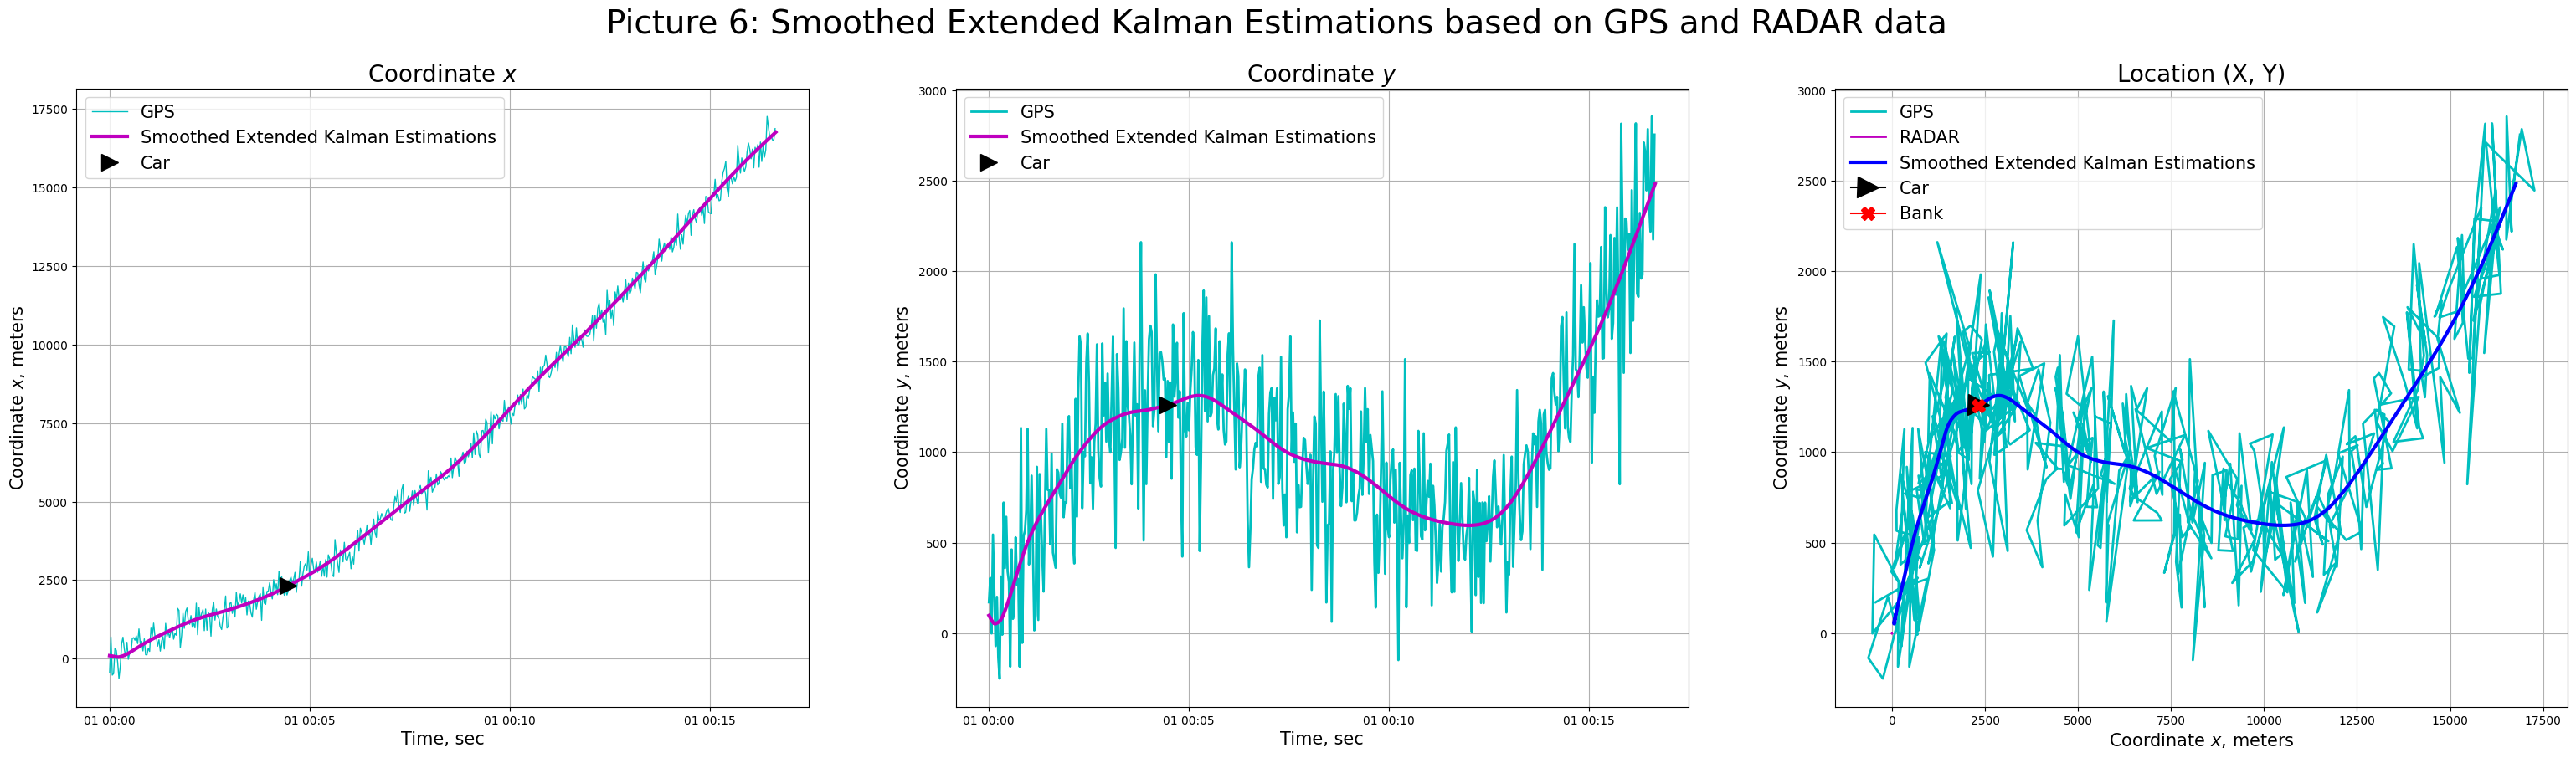

In [88]:
# GPS data plot
# Get the estimated car position
est_4_car_pos = get_pos(est_4.x_sm, est_4.y_sm)

# Set up a figure
fig = plt.figure(figsize=[6.4*6, 4.8*2])
fig.suptitle('Picture 6: Smoothed Extended Kalman Estimations based on GPS and RADAR data ', fontsize=28)

# Coordinate X plot
ax = fig.add_subplot(1, 3, 1)
ax.plot_date(time[::2], z_GPS[0, ::2], lw=1, color='c', ls='-',  label='GPS', marker=None)
ax.plot_date(time, est_4.x_sm, lw=3, color='m', ls='-', label='Smoothed Extended Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_4_car_pos[0], label='Car',  marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_title('Coordinate $x$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Coordinate Y
ax = fig.add_subplot(1, 3, 2)
ax.plot_date(time[::2], z_GPS[1, ::2], lw=2, ls='-', color = 'c',  label='GPS', marker=None)
ax.plot_date(time, est_4.y_sm, lw=3, color='m', ls='-', label='Smoothed Extended Kalman Estimations', marker=None)
# Determining vehicle position
ax.plot_date(car_time, est_4_car_pos[1], label='Car', marker='>', color='k', markersize=15)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Coordinate $y$', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Location (X, Y)
ax = fig.add_subplot(1, 3, 3)
ax.plot(z_GPS[0, ::2], z_GPS[1, ::2], lw=2, color='c', ls='-', marker=None, label='GPS')
ax.plot(*np.asarray(p2c(*z_RADAR))[:, 1::2], lw=2, color='m', ls='-', label='RADAR')
ax.plot(est_4.x_sm, est_4.y_sm, lw=3, color='b', ls='-', label='Smoothed Extended Kalman Estimations')
# Determining vehicle position
ax.plot(*est_4_car_pos, label='Car', marker='>', color='k', markersize=18)
# Plot decoration
ax.grid(True)
ax.set_xlabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Location (X, Y)', fontsize=titlesize)

# Determining position of the bank
ax.plot(*bank, label='Bank', marker='X', color='red', markersize=12)
ax.legend(loc='best', fontsize=labelsize)

plt.show()

In [76]:
# Let's understand how far the car from bank if we assume only RADAR data
get_car_bank_dist(est_4_car_pos)

Car is 3.93 meters far from the bank!


**Conclusion 4:**

According to the smoothed estimated data on GPS and RADAR, it can be said that the car was at the bank at the specified time.

### Step 13:
Plot the results of errors estimations by Kalman Filters.

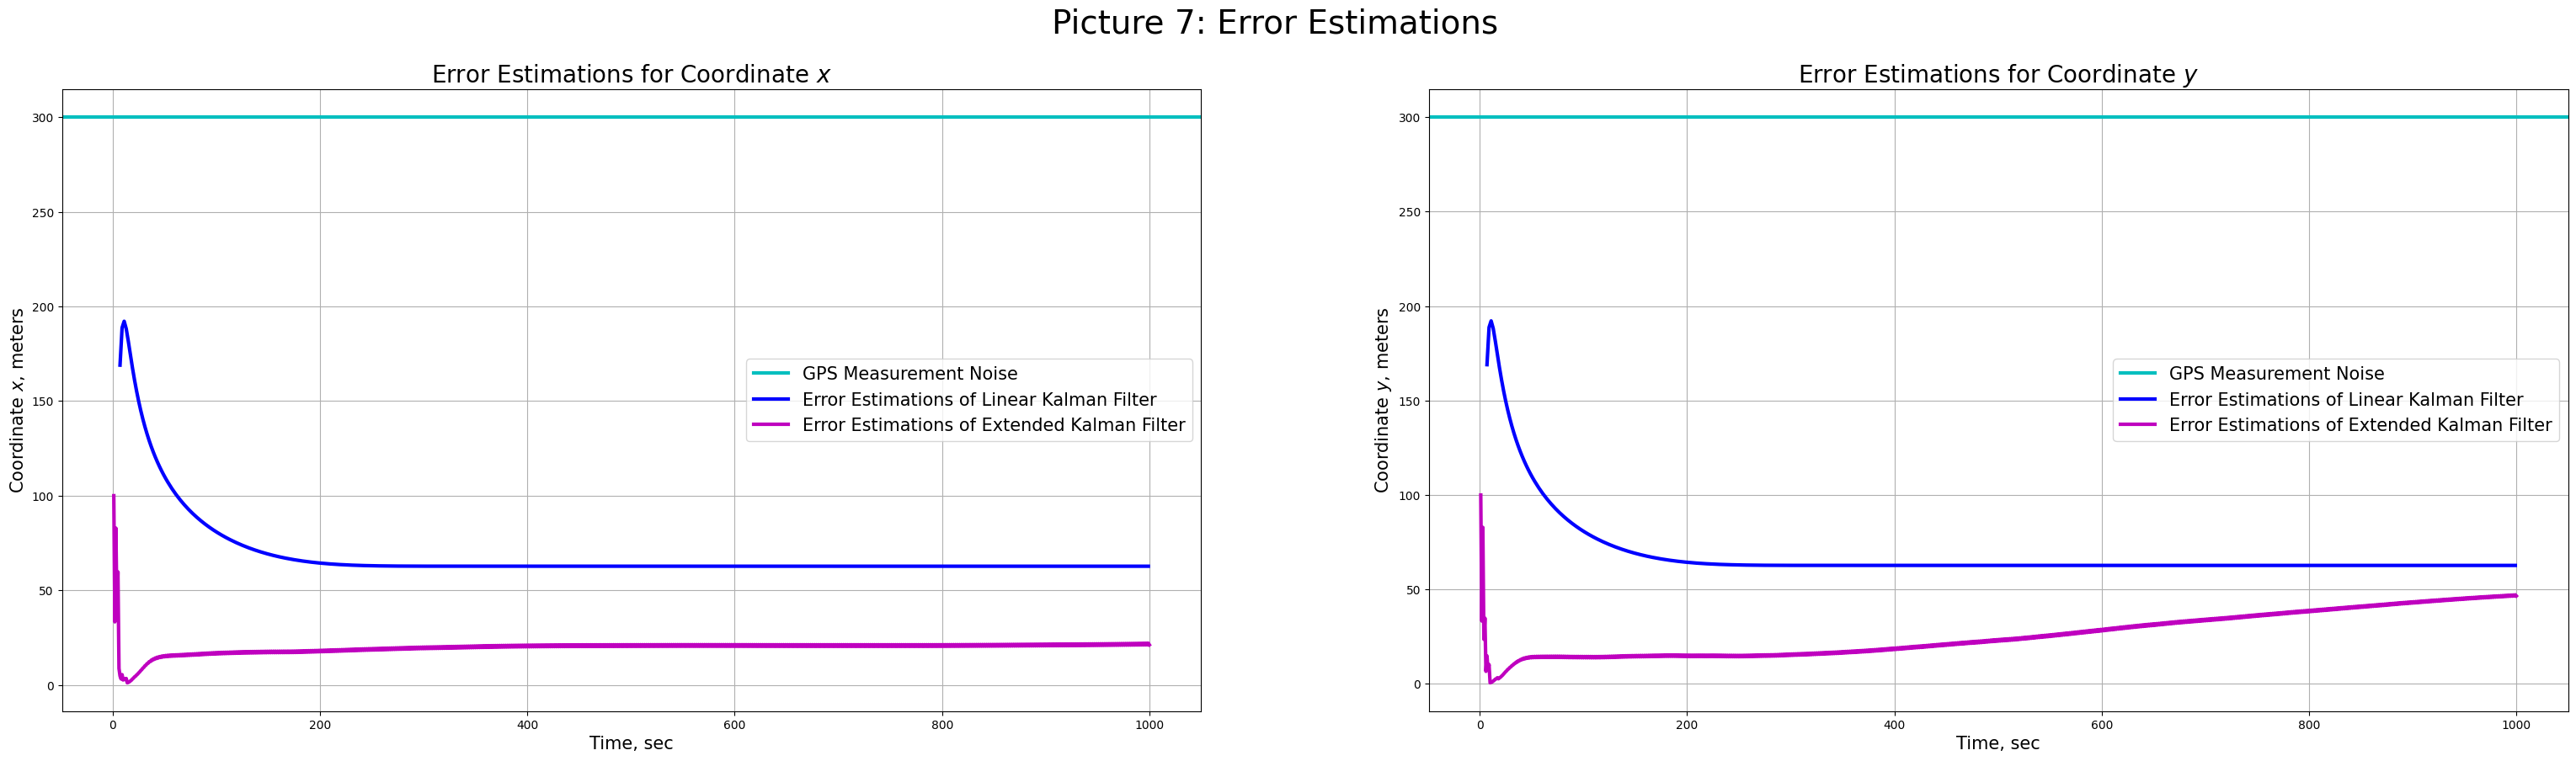

In [89]:
# Set up a figure
fig = plt.figure(figsize=[6.4*6, 4.8*2])
fig.suptitle('Picture 7: Error Estimations', fontsize=28)

# Coordinate X plot
ax = fig.add_subplot(1, 2, 1)
x = np.linspace(1, 1000, 1000)
ax.axhline(y=std_x, lw=3, color='c', linestyle='-', label='GPS Measurement Noise')
ax.plot(x[6::2], np.sqrt(est_1.P_adjust[6::2, 0, 0]), lw=3, ls='-', c ='b',  label='Error Estimations of Linear Kalman Filter')
ax.plot(x, np.sqrt(est_3.P_adjust[:, 0, 0]), lw=3, ls='-', c = 'm', label='Error Estimations of Extended Kalman Filter')
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $x$, meters', fontsize=labelsize)
ax.set_title('Error Estimations for Coordinate $x$ ', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

# Coordinate y plot
ax = fig.add_subplot(1, 2, 2)
x = np.linspace(1, 1000, 1000)
ax.axhline(y=std_x, lw=3, color='c', linestyle='-', label='GPS Measurement Noise')
ax.plot(x[6::2], np.sqrt(est_1.P_adjust[6::2, 2, 2]), lw=3, ls='-', color = 'b', label='Error Estimations of Linear Kalman Filter')
ax.plot(x, np.sqrt(est_3.P_adjust[:, 2, 2]), lw=3, ls='-', color = 'm', label='Error Estimations of Extended Kalman Filter')
# Plot decoration
ax.grid(True)
ax.set_xlabel('Time, sec', fontsize=labelsize)
ax.set_ylabel('Coordinate $y$, meters', fontsize=labelsize)
ax.set_title('Error Estimations for Coordinate $y$ ', fontsize=titlesize)
ax.legend(loc='best', fontsize=labelsize)

plt.show()